
### Why do we need probability theory in statistics?

Probability theory provides us with some essential tools needed for statistics:
  - modelling: describe a population as a probability distribution
  - sampling distributions: distributions obtained for random samples from a population

Additionally, artificially introduced randomness is the basis for two of the most important statistics "kung fu" techniques:

- **random selection** = if you collect a sample of size n randomly selected from a population, then compute statistics from the sample, you can then make inferences about the whole population.
- **random assignment** = create two roughly equivalent groups by randomly assigning participants into group A or group B. This random split is the basis for a statistical experiment that compares an intervention group and a control group. Given the participants were randomly assigned to the two groups, we can hope they are roughly equally distributed on all dimensions (similar distribution of all confounding variables), so that any differences observed between groups can be attributed to the intervention. Calculating the difference statistic intervention-control give an estimate of the effect size of this intervention.

# CUT MATERIAL from 21_prob_theory.ipynb

In [1]:
# load Python modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc={'figure.figsize': (7,4)},
)

%config InlineBackend.figure_format = 'retina'

# # silence annoying warnings
# import warnings; warnings.filterwarnings('ignore')

In [3]:
# set random seed for repeatability
np.random.seed(42)

### Computing prob integrals using quad

#### Uniform

In [4]:
def fU(u):
    if 0 <= u and u <= 1:
        return 1.0
    else:
        return 0.0

In [6]:
from scipy.integrate import quad
quad(fU, -10, 10)[0]

0.9999999999999999

In [7]:
quad(fU, 0.2, 0.5)[0]

0.3

#### Normal

In [8]:
mu = 1000
sigma = 100

def fN(n):
    z = (n - mu)/sigma
    C = sigma * np.sqrt(2*np.pi)
    return 1 / C * np.exp(-1/2 * z**2)

In [9]:
quad(fN, 0, 2000)[0]

1.0000000000000002

We're using limits of integration 0 and 2000 because that function is practically zero outside this range, and function `quad` [needs](https://stackoverflow.com/questions/63673369/while-using-scipy-integrate-quad-increasing-bound-of-a-positive-function-decrea) finite limits of integration to work properly.

In [10]:
quad(fN, 800, 900)[0]

0.13590512198327784

### Computing prob integrals using trapz

In [13]:
from scipy.integrate import trapz

In [14]:
m = 1000
ns = np.linspace(800, 900, m)
fNs = fN(ns)

trapz(fNs, ns)

0.1359051331713763

In [15]:
# how different 
quad(fN, 800, 900)[0] - trapz(fNs, ns)

-1.118809847544533e-08

## Using prob models

In [16]:
# uniform distribution U(0,1)
from sympy import symbols, integrate, Integral, simplify
x, a, b = symbols('x a b')
fU = 1

simplify( integrate(fU, (x,a,b)) )

-a + b

In [17]:
Integral(fU, x)

Integral(1, x)

In [18]:
Integral(fU, x).doit()

x

## Random process examples using Python (bonus material)

Let's look at some simple examples of two random events: a coin flip and a die roll.
We'll use the Python module `random` to generate random numbers.

In [19]:
import random

random.random() # random number between 0 (inclusive) and 1 (non-inclusive)

0.7740103861305342

### Coin flip example

The code example below shows a function that performs the equivalent of a coin flip.

In [20]:
def flip_coin():
    r = random.random()  # a number in the range [0,1)
    if r < 0.5:
        return "heads"
    else:
        return "tails"

flip_coin()

'tails'

#### Flipping a coin many times

Let's see what happens if we flip the coin many times.

heads     976
tails    1024
dtype: int64


<AxesSubplot:>

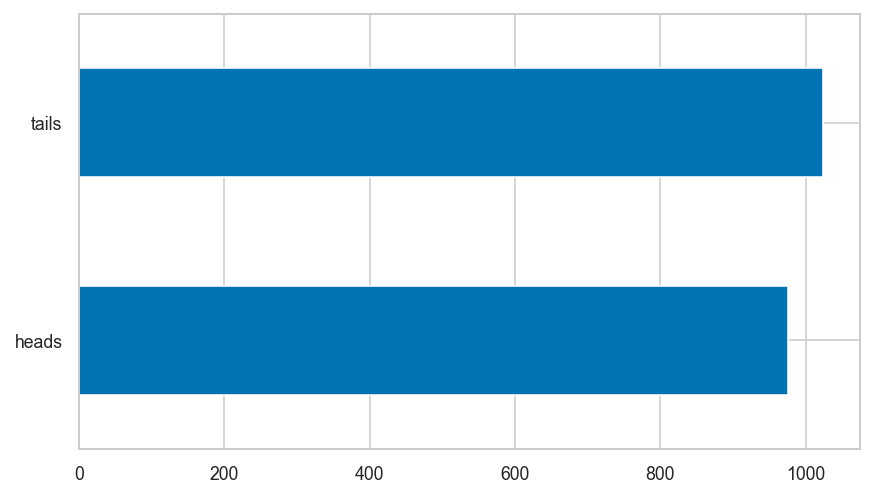

In [21]:
flips = [flip_coin() for _ in range(0, 2000)]
heads = [flip for flip in flips if flip == "heads"]

len(heads)/len(flips)

# plot a horizontal bar chart of the number of outcomes
s = pd.Series(flips)
print(s.value_counts().sort_index())
s.value_counts().sort_index().plot(kind="barh")

### Six-sided die example

In [ ]:
def roll_die():
    r = random.random()*6  # a number in the range [0,6)
    rint = int(r)          # convert to integer in {0,1,2,3,4,5}
    value = rint + 1       # convert to integer in {1,2,3,4,5,6}
    return value

roll_die()

Let's see what happens if we roll the die many times.

In [ ]:

rolls = [roll_die() for _ in range(0, 6000)]
ds = pd.Series(rolls)
print(ds.value_counts().sort_index())
ds.value_counts().sort_index().plot(kind="bar")

#### Intentionally skipped

In [ ]:
rvN.moment(1)  # = rvN.mean()

In [ ]:
# Let's verify the formula:
# E[(x-𝜇)^2]  = E[X^2]         -   E[X]^2
#               second moment      first moment squared
rvN.var()    == rvN.moment(2)  -   rvN.moment(1)**2

In [ ]:
from scipy.stats.distributions import norm

# 1. choose the parameters:
mean = 1000   # 𝜇 (mu)    = where is its center?
std = 100     # 𝜎 (sigma) = how spread out is it?

# 2. create a normal random variable
rvN = norm(mean, std)

# 3. plot it's probability density function (pdf)
x = np.linspace(rvN.ppf(0.001), rvN.ppf(0.999), 10000)
y = rvN.pdf(x)
ax = sns.lineplot(x=x, y=y)
title = 'Probability density for the normal distribution $\mathcal{N}('+ str(mean) + ',' + str(std) + ')$'
ax.set_title(title)
ax.set_xlim(300,1700)
plt.xticks(np.arange(400,1700,100))
_ = ax.set_ylim(0, 0.006)

In [ ]:
rvN.entropy()

In [ ]:
0.5*np.log(2*np.pi*sigma**2) + 0.5